# Imports and Config

In [1]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Scikit-learn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


# Load dataset

In [2]:
df = pd.read_csv('/kaggle/input/merged-data-housea-day30-with-features-csv/merged_data_HouseA_DAY30_with_features.csv')

print(df.shape)
df.head()


(2592000, 28)


,Unnamed: 0,ph1,ph2,ir1,fo1,fo2,di3,di4,ph3,ph4,...,di2,te1,fo3,activity1,activity2,Timestamp,hour,minute,dayofweek,is_weekend
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,12,17,2024-01-01 00:00:00,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,12,17,2024-01-01 00:00:01,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,12,17,2024-01-01 00:00:02,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,12,17,2024-01-01 00:00:03,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,12,17,2024-01-01 00:00:04,0,0,0,0


# Preprocessing + compute class weights

In [3]:
# Convert labels
activity1_labels = df['activity1'].values - 1

# Unique classes
unique_classes = np.unique(activity1_labels)
NUM_CLASSES = len(unique_classes)

# LabelEncoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(unique_classes)

# Transform labels → safe for CE
activity1_labels_encoded = label_encoder.transform(activity1_labels)

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(NUM_CLASSES),
    y=activity1_labels_encoded
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print('Class_weights:', class_weights)

# Print check
print(f"NUM_CLASSES = {NUM_CLASSES}, class_weights.shape = {weights_tensor.shape}")


Class_weights: [ 1.66187084  0.28895567  2.92215698  2.04379654  3.44920277  4.26892937
  2.96121629  4.08792831  4.22120962  4.70490857  0.11682382  0.32856966
  0.7253251   2.66828081  1.636124    6.05664081  0.34413801  1.8132138
 24.26784511  5.2263333   0.8638399   6.92451953 24.04541913  6.28299664
 16.63201663  6.09180004]
NUM_CLASSES = 26, class_weights.shape = torch.Size([26])


In [4]:
df.columns[1:21]

Index(['ph1', 'ph2', 'ir1', 'fo1', 'fo2', 'di3', 'di4', 'ph3', 'ph4', 'ph5',
       'ph6', 'co1', 'co2', 'co3', 'so1', 'so2', 'di1', 'di2', 'te1', 'fo3'],
      dtype='object')

# Rolling buffer definitions

In [5]:
# Define constants
SHORT_WINDOW_SEC = 300      # past 1 min → 60 timesteps (since data is 1Hz)
LONG_HISTORY_HOURS = 24
CHUNK_SIZE_SEC = 30
CHUNK_STRIDE_MIN = 5

# Derived
CHUNK_STRIDE_SEC = CHUNK_STRIDE_MIN * 60
NUM_LONG_CHUNKS = (LONG_HISTORY_HOURS * 3600) // CHUNK_STRIDE_SEC

print(f"Long context → {NUM_LONG_CHUNKS} chunks, each {CHUNK_SIZE_SEC} seconds")

# Sensor columns (1-based index in CSV → adjust as per your df)
sensor_columns = df.columns[1:21]
num_sensors = len(sensor_columns)

# Convert full sensor data to numpy array
sensor_data = df[sensor_columns].values  # shape: (N, 20)
activity1_labels = df['activity1'].values - 1  # shape: (N,)
timestamps = pd.to_datetime(df['Timestamp'])


Long context → 288 chunks, each 30 seconds


# Dataset class for training

In [6]:
class ActivityDataset(Dataset):
    def __init__(self, sensor_data, labels, timestamps,
                 short_window_sec=60, long_history_hours=12,
                 chunk_size_sec=30, chunk_stride_min=5):
        
        self.sensor_data = sensor_data
        self.labels = labels
        self.timestamps = timestamps
        
        self.short_window = short_window_sec
        self.chunk_size = chunk_size_sec
        self.chunk_stride = chunk_stride_min * 60
        
        self.num_long_chunks = (long_history_hours * 3600) // self.chunk_stride
        
        # We'll skip first 12h to have full long history
        self.start_idx = int(long_history_hours * 3600)
    
    def __len__(self):
        return len(self.labels) - self.start_idx
    
    def __getitem__(self, idx):
        true_idx = idx + self.start_idx
        
        # Short window
        short_start = true_idx - self.short_window
        short_window = self.sensor_data[short_start:true_idx]
        
        # Long window (sampled chunks)
        long_chunks = []
        for i in range(self.num_long_chunks):
            chunk_center = true_idx - i * self.chunk_stride
            chunk_start = chunk_center - self.chunk_size // 2
            chunk_end = chunk_center + self.chunk_size // 2
            chunk = self.sensor_data[chunk_start:chunk_end]
            # Aggregate chunk (mean over time dimension)
            chunk_mean = chunk.mean(axis=0)
            long_chunks.append(chunk_mean)
        
        long_chunks = np.stack(long_chunks[::-1], axis=0)  # oldest first
        
        # Time features
        ts = self.timestamps[true_idx]
        hour_sin = np.sin(2 * np.pi * ts.hour / 24)
        hour_cos = np.cos(2 * np.pi * ts.hour / 24)
        dow_sin = np.sin(2 * np.pi * ts.dayofweek / 7)
        dow_cos = np.cos(2 * np.pi * ts.dayofweek / 7)
        is_weekend = int(ts.dayofweek >= 5)
        
        time_feats = np.array([hour_sin, hour_cos, dow_sin, dow_cos, is_weekend], dtype=np.float32)
        
        # Target
        target = self.labels[true_idx]
        
        # Convert to tensors
        short_window = torch.tensor(short_window, dtype=torch.float32)
        long_chunks = torch.tensor(long_chunks, dtype=torch.float32)
        time_feats = torch.tensor(time_feats, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.long)
        
        return short_window, long_chunks, time_feats, target


# DataLoader setup

In [7]:
# Create dataset
dataset = ActivityDataset(sensor_data, activity1_labels_encoded, timestamps)

# Split train/test
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoaders
BATCH_SIZE = 1024

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Train batches: 1991, Val batches: 498


# TCN Block

In [8]:
# TCN block definition (generic) 
# Based on standard TCN architecture (dilated causal convolutions)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        """
        num_inputs: number of input features per timestep (e.g. 20 sensors)
        num_channels: list of number of channels in each layer (controls depth/receptive field)
        """
        super(TemporalConvNet, self).__init__()
        
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            layers += [
                nn.Conv1d(in_channels, out_channels, kernel_size, 
                          stride=1, padding=(kernel_size-1)*dilation_size, dilation=dilation_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Conv1d(out_channels, out_channels, kernel_size, 
                          stride=1, padding=(kernel_size-1)*dilation_size, dilation=dilation_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        x: shape (batch, features, timesteps)
        """
        out = self.network(x)
        # Remove extra padding: return same shape as input (causal padding)
        return out[:, :, -x.size(2):]


# Short context model

In [9]:
# Short-context TCN model 

class ShortTCNModel(nn.Module):
    def __init__(self, input_dim, tcn_channels, output_dim):
        """
        input_dim: number of input features per timestep (20 sensors)
        tcn_channels: list of channels (e.g. [64, 64, 64])
        output_dim: embedding size to output (for fusion)
        """
        super(ShortTCNModel, self).__init__()
        
        self.tcn = TemporalConvNet(input_dim, tcn_channels)
        
        # Final pooling + MLP head → output embedding
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),  # global pooling over time
            nn.Flatten(),
            nn.Linear(tcn_channels[-1], output_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        """
        x: (batch, timesteps, features) → need to permute to (batch, features, timesteps)
        """
        x = x.permute(0, 2, 1)
        tcn_out = self.tcn(x)
        out = self.fc(tcn_out)
        return out


# Long Context model

In [10]:
# Long-context TCN model 

class LongTCNModel(nn.Module):
    def __init__(self, input_dim, tcn_channels, output_dim):
        """
        input_dim: number of input features per "chunk" (same 20 sensors → aggregated per chunk)
        tcn_channels: list of channels (e.g. [64, 64, 64])
        output_dim: embedding size to output (for fusion)
        """
        super(LongTCNModel, self).__init__()
        
        self.tcn = TemporalConvNet(input_dim, tcn_channels)
        
        # Final pooling + MLP head → output embedding
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(tcn_channels[-1], output_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        """
        x: (batch, chunks, features) → permute to (batch, features, chunks)
        """
        x = x.permute(0, 2, 1)
        tcn_out = self.tcn(x)
        out = self.fc(tcn_out)
        return out


# Fusion MLP

In [11]:
# Fusion MLP 

class FusionModel(nn.Module):
    def __init__(self, short_embed_dim, long_embed_dim, time_feat_dim, num_classes):
        """
        short_embed_dim: output size of Short TCN
        long_embed_dim: output size of Long TCN
        time_feat_dim: number of time features (5 → sin/cos hour, sin/cos dow, is_weekend)
        num_classes: number of activity classes
        """
        super(FusionModel, self).__init__()
        
        fusion_input_dim = short_embed_dim + long_embed_dim + time_feat_dim + num_sensors  # + sensors
        
        self.fc = nn.Sequential(
            nn.Linear(fusion_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, sensor_now, short_embed, long_embed, time_feats):
        """
        sensor_now: (batch, num_sensors)
        short_embed: (batch, short_embed_dim)
        long_embed: (batch, long_embed_dim)
        time_feats: (batch, time_feat_dim)
        """
        x = torch.cat([sensor_now, short_embed, long_embed, time_feats], dim=1)
        logits = self.fc(x)
        return logits


# Set Hyperparameters

In [12]:
# Hyperparameters
SHORT_TCN_CHANNELS = [64, 64, 64]
LONG_TCN_CHANNELS = [64, 64, 64]
EMBED_DIM = 64  # embedding size for both short and long
TIME_FEAT_DIM = 5  # hour sin/cos, dow sin/cos, is_weekend

# Number of classes → from your unique_classes
NUM_CLASSES = len(np.unique(activity1_labels))

# Loss function → Weighted CE

In [13]:
# Loss function → Weighted CE
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Training loop skeleton — with Weighted CE

In [14]:
## Instantiate models
#short_model = ShortTCNModel(input_dim=num_sensors, 
#                            tcn_channels=SHORT_TCN_CHANNELS, 
#                            output_dim=EMBED_DIM).to(device)
#
#long_model = LongTCNModel(input_dim=num_sensors, 
#                          tcn_channels=LONG_TCN_CHANNELS, 
#                          output_dim=EMBED_DIM).to(device)
#
#fusion_model = FusionModel(short_embed_dim=EMBED_DIM, 
#                           long_embed_dim=EMBED_DIM, 
#                           time_feat_dim=TIME_FEAT_DIM, 
#                           num_classes=NUM_CLASSES).to(device)
#
## Optimizer
#optimizer = torch.optim.Adam(list(short_model.parameters()) + 
#                             list(long_model.parameters()) + 
#                             list(fusion_model.parameters()), lr=1e-3)
#
## Loss function → Weighted CE
#criterion = nn.CrossEntropyLoss(weight=weights_tensor)
#
## Training loop
#EPOCHS = 3
#
#for epoch in range(EPOCHS):
#    short_model.train()
#    long_model.train()
#    fusion_model.train()
#    
#    running_loss = 0.0
#    
#    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
#        short_window, long_chunks, time_feats, target = batch
#        
#        short_window = short_window.to(device)
#        long_chunks = long_chunks.to(device)
#        time_feats = time_feats.to(device)
#        target = target.to(device)
#        
#        # Forward pass
#        short_embed = short_model(short_window)
#        long_embed = long_model(long_chunks)
#        
#        # Current sensor state → last timestep from short window
#        sensor_now = short_window[:, -1, :]  # shape: (batch, num_sensors)
#        
#        logits = fusion_model(sensor_now, short_embed, long_embed, time_feats)
#        
#        # Loss
#        loss = criterion(logits, target)
#        
#        # Backprop
#        optimizer.zero_grad()
#        loss.backward()
#        optimizer.step()
#        
#        running_loss += loss.item()
#    
#    avg_loss = running_loss / len(train_loader)
#    print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}")
#    
#    # Optional: Add validation loop here if you want
#


# Save models with LabelEncoder

In [15]:
## Save models
#
#torch.save(short_model.state_dict(), "short_tcn_model.pth")
#torch.save(long_model.state_dict(), "long_tcn_model.pth")
#torch.save(fusion_model.state_dict(), "fusion_model.pth")
#
## Save LabelEncoder (very important!)
#import pickle
#
#with open("label_encoder.pkl", "wb") as f:
#    pickle.dump(label_encoder, f)
#
#print("Models and LabelEncoder saved!")


# Load models and LabelEncoder

In [16]:
# Load models

# Recreate models with same architecture
short_model = ShortTCNModel(input_dim=num_sensors, tcn_channels=SHORT_TCN_CHANNELS, output_dim=EMBED_DIM).to(device)
long_model = LongTCNModel(input_dim=num_sensors, tcn_channels=LONG_TCN_CHANNELS, output_dim=EMBED_DIM).to(device)
fusion_model = FusionModel(short_embed_dim=EMBED_DIM, long_embed_dim=EMBED_DIM, time_feat_dim=TIME_FEAT_DIM, num_classes=NUM_CLASSES).to(device)

# Load weights for gpu
short_model.load_state_dict(torch.load("/kaggle/input/v1/other/default/1/short_tcn_model.pth"))
long_model.load_state_dict(torch.load("/kaggle/input/v1/other/default/1/long_tcn_model.pth"))
fusion_model.load_state_dict(torch.load("/kaggle/input/v1/other/default/1/fusion_model.pth"))

# Load weights for cpu
#short_model.load_state_dict(torch.load("/kaggle/input/fusion/short_tcn_model.pth", map_location=torch.device('cpu')))
#long_model.load_state_dict(torch.load("/kaggle/input/fusion/long_tcn_model.pth", map_location=torch.device('cpu')))
#fusion_model.load_state_dict(torch.load("/kaggle/input/fusion/fusion_model.pth", map_location=torch.device('cpu')))

short_model.eval()
long_model.eval()
fusion_model.eval()

# Load LabelEncoder
import pickle
with open("/kaggle/input/v1/other/default/1/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

print("Models and LabelEncoder loaded!")


Models and LabelEncoder loaded!


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Validation Loop

In [17]:
# Validation Loop

def validate(short_model, long_model, fusion_model, val_loader, criterion):
    short_model.eval()
    long_model.eval()
    fusion_model.eval()
    
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            short_window, long_chunks, time_feats, target = batch
            
            short_window = short_window.to(device)
            long_chunks = long_chunks.to(device)
            time_feats = time_feats.to(device)
            target = target.to(device)
            
            # Forward pass
            short_embed = short_model(short_window)
            long_embed = long_model(long_chunks)
            
            sensor_now = short_window[:, -1, :]  # last timestep
            
            logits = fusion_model(sensor_now, short_embed, long_embed, time_feats)
            
            # Loss
            loss = criterion(logits, target)
            val_loss += loss.item()
            
            # Accuracy
            preds = torch.argmax(logits, dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    
    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total
    
    print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {accuracy:.4f}")
    
    return avg_val_loss, accuracy

# After training loop → run validation:
val_loss, val_acc = validate(short_model, long_model, fusion_model, val_loader, criterion)



Validating:   0%|          | 0/498 [00:00<?, ?it/s]

Validation Loss: 0.2109 | Validation Accuracy: 0.9233


# Real-time inference class

In [18]:
# Real-time inference

def run_realtime_inference(current_idx, sensor_data, timestamps,
                           short_model, long_model, fusion_model, label_encoder):
    short_model.eval()
    long_model.eval()
    fusion_model.eval()
    
    # ----- Prepare short window -----
    short_start = current_idx - SHORT_WINDOW_SEC
    short_window = sensor_data[short_start:current_idx]  # shape: (short_window, num_sensors)
    short_window = torch.tensor(short_window, dtype=torch.float32).unsqueeze(0).to(device)  # (1, timesteps, features)
    
    # ----- Prepare long context -----
    long_chunks = []
    for i in range((LONG_HISTORY_HOURS * 3600) // (CHUNK_STRIDE_MIN * 60)):
        chunk_center = current_idx - i * (CHUNK_STRIDE_MIN * 60)
        chunk_start = chunk_center - CHUNK_SIZE_SEC // 2
        chunk_end = chunk_center + CHUNK_SIZE_SEC // 2
        chunk = sensor_data[chunk_start:chunk_end]
        chunk_mean = chunk.mean(axis=0)
        long_chunks.append(chunk_mean)
    
    long_chunks = np.stack(long_chunks[::-1], axis=0)  # oldest first
    long_chunks = torch.tensor(long_chunks, dtype=torch.float32).unsqueeze(0).to(device)  # (1, chunks, features)
    
    # ----- Prepare time features -----
    ts = timestamps[current_idx]
    hour_sin = np.sin(2 * np.pi * ts.hour / 24)
    hour_cos = np.cos(2 * np.pi * ts.hour / 24)
    dow_sin = np.sin(2 * np.pi * ts.dayofweek / 7)
    dow_cos = np.cos(2 * np.pi * ts.dayofweek / 7)
    is_weekend = int(ts.dayofweek >= 5)
    
    time_feats = np.array([hour_sin, hour_cos, dow_sin, dow_cos, is_weekend], dtype=np.float32)
    time_feats = torch.tensor(time_feats, dtype=torch.float32).unsqueeze(0).to(device)  # (1, time_feats)
    
    # ----- Prepare current sensor state -----
    sensor_now = torch.tensor(sensor_data[current_idx], dtype=torch.float32).unsqueeze(0).to(device)  # (1, num_sensors)
    
    # ----- Run through models -----
    with torch.no_grad():
        short_embed = short_model(short_window)
        long_embed = long_model(long_chunks)
        
        logits = fusion_model(sensor_now, short_embed, long_embed, time_feats)
        probs = torch.softmax(logits, dim=1)
        pred_class_idx = torch.argmax(probs, dim=1).item()
    
    # Map back to original activity ID
    pred_activity_id = label_encoder.inverse_transform([pred_class_idx])[0]
    pred_confidence = probs[0, pred_class_idx].item()
    
    return pred_activity_id, pred_confidence


# Real-time inference loop

In [19]:
# Real-time inference loop

# How many samples to test:
N_SAMPLES = 50  # you can change to 50, 100, etc.

# Compute min_idx to ensure enough history
required_history = (LONG_HISTORY_HOURS * 3600)
min_idx = required_history + SHORT_WINDOW_SEC

print(f"Running real-time inference on {N_SAMPLES} random timestamps")
print("="*80)

for i in range(N_SAMPLES):
    # Pick random index
    current_idx = random.randint(min_idx, len(sensor_data)-1)
    
    # Run inference
    pred_activity, pred_conf = run_realtime_inference(current_idx, sensor_data, timestamps,
                                                      short_model, long_model, fusion_model, label_encoder)
    
    # Get ACTUAL activity from dataset → remember your labels were LabelEncoded
    # So we need to map current label back:
    actual_encoded_label = activity1_labels_encoded[current_idx]
    actual_activity_id = label_encoder.inverse_transform([actual_encoded_label])[0]
    
    # Print result
    print(f"[{i+1}/{N_SAMPLES}] Time: {timestamps[current_idx]} | Index: {current_idx}")
    print(f"  Actual Activity:    {actual_activity_id}")
    print(f"  Predicted Activity: {pred_activity} | Confidence: {pred_conf:.4f}")
    print("-"*80)


Running real-time inference on 50 random timestamps
[1/50] Time: 2024-01-10 10:47:37 | Index: 816457
  Actual Activity:    11
  Predicted Activity: 10 | Confidence: 0.9987
--------------------------------------------------------------------------------
[2/50] Time: 2024-01-23 02:42:24 | Index: 1910544
  Actual Activity:    10
  Predicted Activity: 10 | Confidence: 0.9990
--------------------------------------------------------------------------------
[3/50] Time: 2024-01-29 23:14:45 | Index: 2502885
  Actual Activity:    11
  Predicted Activity: 11 | Confidence: 0.9092
--------------------------------------------------------------------------------
[4/50] Time: 2024-01-18 17:22:23 | Index: 1531343
  Actual Activity:    5
  Predicted Activity: 5 | Confidence: 0.9816
--------------------------------------------------------------------------------
[5/50] Time: 2024-01-30 13:33:42 | Index: 2554422
  Actual Activity:    14
  Predicted Activity: 14 | Confidence: 0.9974
----------------------

# CONFUSION MATRIX BLOCK

Computing Confusion Matrix:   0%|          | 0/498 [00:00<?, ?it/s]

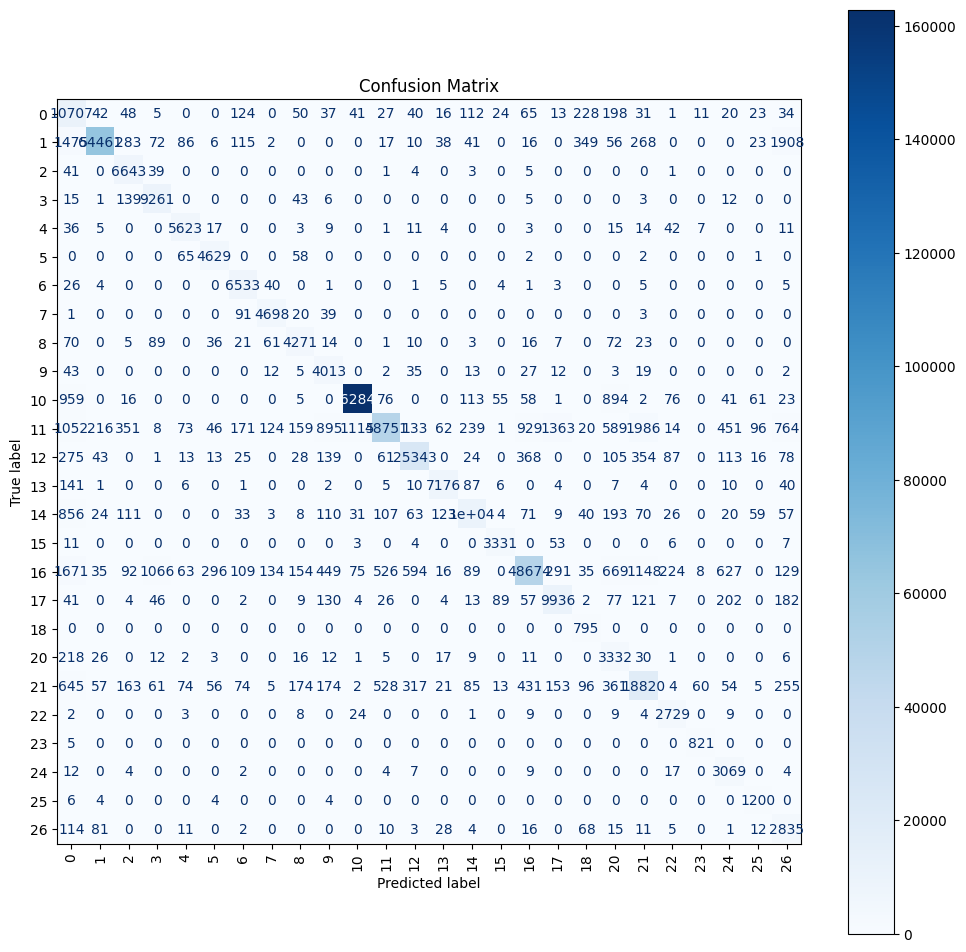

In [20]:
# CONFUSION MATRIX BLOCK

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Function to compute confusion matrix on val_loader
def compute_confusion_matrix(short_model, long_model, fusion_model, val_loader, label_encoder):
    short_model.eval()
    long_model.eval()
    fusion_model.eval()
    
    all_targets = []
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Computing Confusion Matrix"):
            short_window, long_chunks, time_feats, target = batch
            
            short_window = short_window.to(device)
            long_chunks = long_chunks.to(device)
            time_feats = time_feats.to(device)
            target = target.to(device)
            
            # Forward pass
            short_embed = short_model(short_window)
            long_embed = long_model(long_chunks)
            sensor_now = short_window[:, -1, :]  # last timestep
            logits = fusion_model(sensor_now, short_embed, long_embed, time_feats)
            
            preds = torch.argmax(logits, dim=1)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Convert back to original activity IDs (using inverse_transform)
    all_targets_original = label_encoder.inverse_transform(all_targets)
    all_preds_original = label_encoder.inverse_transform(all_preds)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets_original, all_preds_original, labels=label_encoder.classes_)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=label_encoder.classes_)
    disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()
    
    return cm



cm = compute_confusion_matrix(short_model, long_model, fusion_model, val_loader, label_encoder)


# PER-CLASS ACCURACY REPORT

In [21]:
# PER-CLASS ACCURACY REPORT

from sklearn.metrics import classification_report

def per_class_accuracy_report(short_model, long_model, fusion_model, val_loader, label_encoder):
    short_model.eval()
    long_model.eval()
    fusion_model.eval()
    
    all_targets = []
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Per-class Accuracy Report"):
            short_window, long_chunks, time_feats, target = batch
            
            short_window = short_window.to(device)
            long_chunks = long_chunks.to(device)
            time_feats = time_feats.to(device)
            target = target.to(device)
            
            # Forward pass
            short_embed = short_model(short_window)
            long_embed = long_model(long_chunks)
            sensor_now = short_window[:, -1, :]
            logits = fusion_model(sensor_now, short_embed, long_embed, time_feats)
            
            preds = torch.argmax(logits, dim=1)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Convert back to original activity IDs
    all_targets_original = label_encoder.inverse_transform(all_targets)
    all_preds_original = label_encoder.inverse_transform(all_preds)
    
    # Classification report
    report = classification_report(all_targets_original, all_preds_original, labels=label_encoder.classes_)
    print(report)
    
    return report

report = per_class_accuracy_report(short_model, long_model, fusion_model, val_loader, label_encoder)



Per-class Accuracy Report:   0%|          | 0/498 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.58      0.90      0.71     11897
           1       0.99      0.93      0.96     69226
           2       0.85      0.99      0.91      6737
           3       0.87      0.98      0.92      9485
           4       0.93      0.97      0.95      5801
           5       0.91      0.97      0.94      4757
           6       0.89      0.99      0.94      6628
           7       0.92      0.97      0.95      4852
           8       0.85      0.91      0.88      4699
           9       0.67      0.96      0.79      4186
          10       0.99      0.99      0.99    165224
          11       0.97      0.82      0.89     59608
          12       0.95      0.94      0.94     27086
          13       0.96      0.96      0.96      7500
          14       0.92      0.83      0.88     12163
          15       0.94      0.98      0.96      3415
          16       0.96      0.85      0.90     57174
          17       0.84    

# ACCURACY OVER TIME PLOT

Accuracy Over Time:   0%|          | 0/4176 [00:00<?, ?it/s]

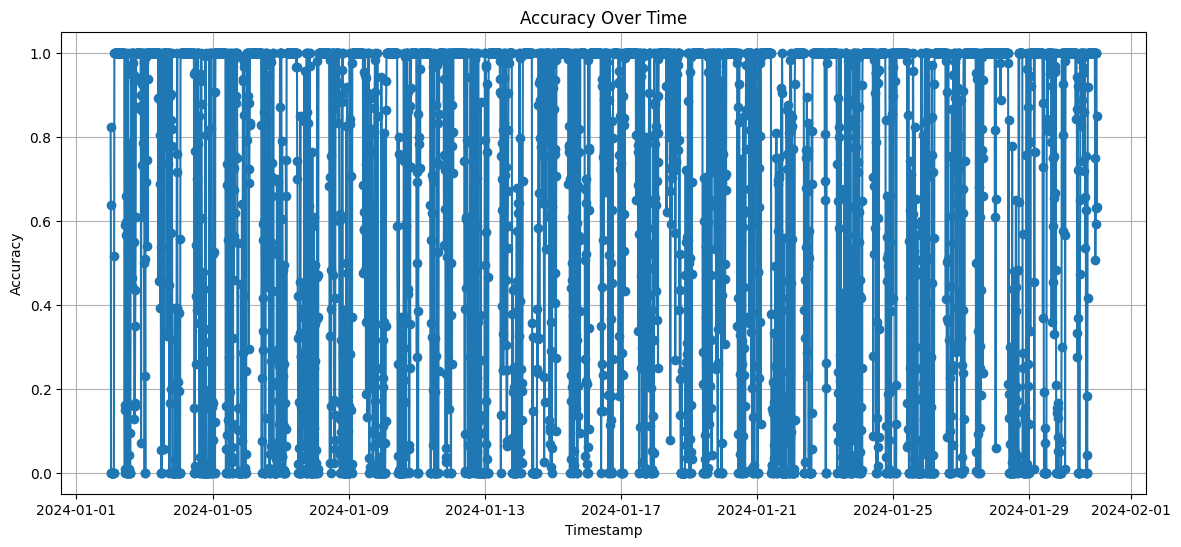

In [22]:
# ACCURACY OVER TIME PLOT

def accuracy_over_time_plot(short_model, long_model, fusion_model,
                            sensor_data, timestamps, activity_labels_encoded, label_encoder,
                            window_stride_sec=600):
    short_model.eval()
    long_model.eval()
    fusion_model.eval()
    
    required_history = (LONG_HISTORY_HOURS * 3600)
    min_idx = required_history + SHORT_WINDOW_SEC
    
    indices = []
    accuracies = []
    
    with torch.no_grad():
        for current_idx in tqdm(range(min_idx, len(sensor_data), window_stride_sec), desc="Accuracy Over Time"):
            window_indices = range(current_idx, min(current_idx + window_stride_sec, len(sensor_data)))
            
            correct = 0
            total = 0
            
            for idx in window_indices:
                # Prepare short window
                short_start = idx - SHORT_WINDOW_SEC
                short_window = sensor_data[short_start:idx]
                short_window = torch.tensor(short_window, dtype=torch.float32).unsqueeze(0).to(device)
                
                # Prepare long context
                long_chunks = []
                for i in range((LONG_HISTORY_HOURS * 3600) // (CHUNK_STRIDE_MIN * 60)):
                    chunk_center = idx - i * (CHUNK_STRIDE_MIN * 60)
                    chunk_start = chunk_center - CHUNK_SIZE_SEC // 2
                    chunk_end = chunk_center + CHUNK_SIZE_SEC // 2
                    chunk = sensor_data[chunk_start:chunk_end]
                    chunk_mean = chunk.mean(axis=0)
                    long_chunks.append(chunk_mean)
                
                long_chunks = np.stack(long_chunks[::-1], axis=0)
                long_chunks = torch.tensor(long_chunks, dtype=torch.float32).unsqueeze(0).to(device)
                
                # Time features
                ts = timestamps[idx]
                hour_sin = np.sin(2 * np.pi * ts.hour / 24)
                hour_cos = np.cos(2 * np.pi * ts.hour / 24)
                dow_sin = np.sin(2 * np.pi * ts.dayofweek / 7)
                dow_cos = np.cos(2 * np.pi * ts.dayofweek / 7)
                is_weekend = int(ts.dayofweek >= 5)
                time_feats = np.array([hour_sin, hour_cos, dow_sin, dow_cos, is_weekend], dtype=np.float32)
                time_feats = torch.tensor(time_feats, dtype=torch.float32).unsqueeze(0).to(device)
                
                # Current sensor state
                sensor_now = torch.tensor(sensor_data[idx], dtype=torch.float32).unsqueeze(0).to(device)
                
                # Forward pass
                short_embed = short_model(short_window)
                long_embed = long_model(long_chunks)
                logits = fusion_model(sensor_now, short_embed, long_embed, time_feats)
                preds = torch.argmax(logits, dim=1).cpu().item()
                
                # Ground truth
                target = activity_labels_encoded[idx]
                
                if preds == target:
                    correct += 1
                total += 1
            
            # Compute accuracy for this window
            acc = correct / total if total > 0 else 0
            accuracies.append(acc)
            indices.append(timestamps[current_idx])
    
    # Plot
    plt.figure(figsize=(14,6))
    plt.plot(indices, accuracies, marker='o')
    plt.title("Accuracy Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()
    
    return indices, accuracies

indices, accuracies = accuracy_over_time_plot(short_model, long_model, fusion_model,
                                              sensor_data, timestamps, activity1_labels_encoded, label_encoder,
                                              window_stride_sec=600)  # 10 min stride



# CONFIDENCE ANALYSIS BLOCK

Confidence Analysis:   0%|          | 0/498 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


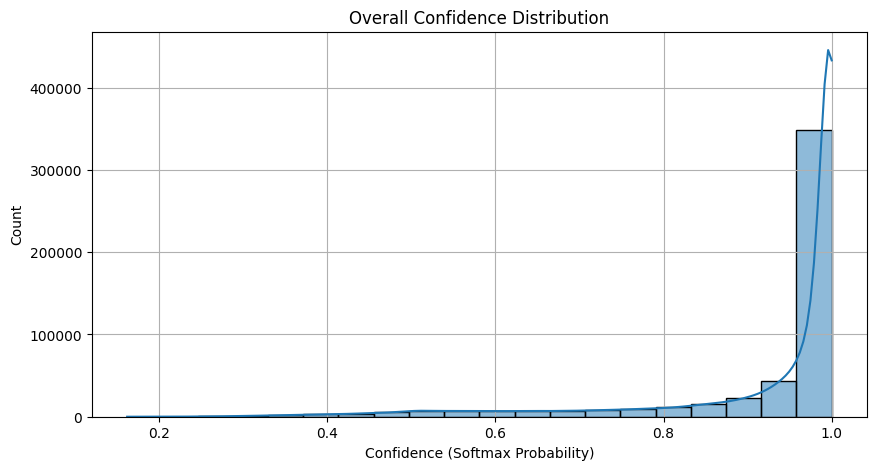

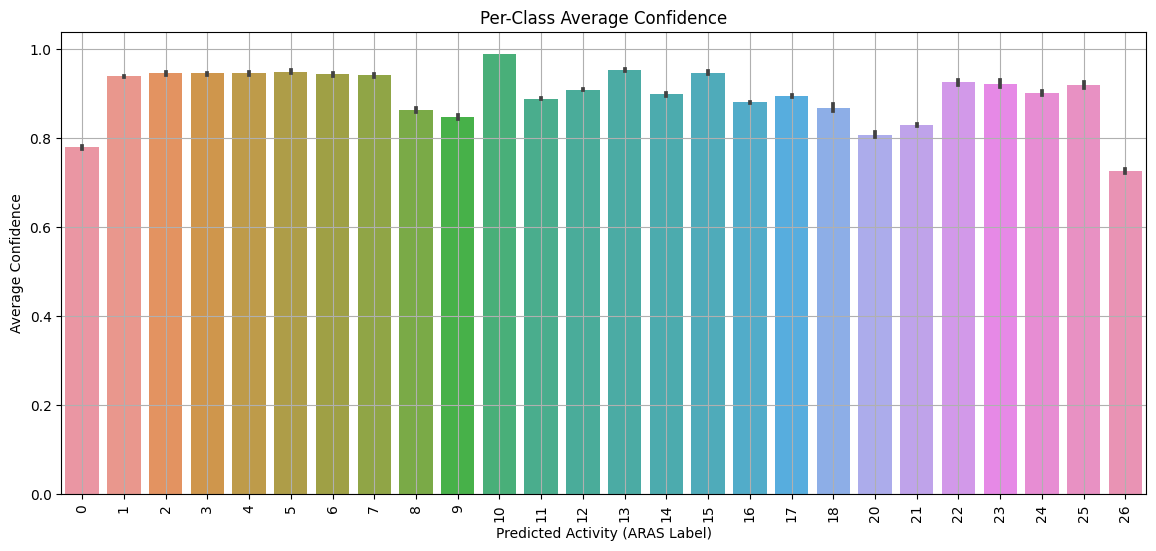

In [23]:
# CONFIDENCE ANALYSIS BLOCK

import seaborn as sns
import matplotlib.pyplot as plt

def confidence_analysis_plot(short_model, long_model, fusion_model, val_loader, label_encoder):
    short_model.eval()
    long_model.eval()
    fusion_model.eval()
    
    all_targets = []
    all_preds = []
    all_confidences = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Confidence Analysis"):
            short_window, long_chunks, time_feats, target = batch
            
            short_window = short_window.to(device)
            long_chunks = long_chunks.to(device)
            time_feats = time_feats.to(device)
            target = target.to(device)
            
            # Forward pass
            short_embed = short_model(short_window)
            long_embed = long_model(long_chunks)
            sensor_now = short_window[:, -1, :]
            logits = fusion_model(sensor_now, short_embed, long_embed, time_feats)
            
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            confidences = probs[torch.arange(probs.size(0)), preds].cpu().numpy()
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_confidences.extend(confidences)
    
    # Convert back to original activity IDs
    all_targets_original = label_encoder.inverse_transform(all_targets)
    all_preds_original = label_encoder.inverse_transform(all_preds)
    
    # Create dataframe for seaborn
    import pandas as pd
    df_conf = pd.DataFrame({
        "TrueActivity": all_targets_original,
        "PredictedActivity": all_preds_original,
        "Confidence": all_confidences
    })
    
    # PLOT 1: Histogram of overall confidence
    plt.figure(figsize=(10,5))
    sns.histplot(df_conf["Confidence"], bins=20, kde=True)
    plt.title("Overall Confidence Distribution")
    plt.xlabel("Confidence (Softmax Probability)")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()
    
    # PLOT 2: Per-class average confidence
    plt.figure(figsize=(14,6))
    sns.barplot(x="PredictedActivity", y="Confidence", data=df_conf)
    plt.title("Per-Class Average Confidence")
    plt.xlabel("Predicted Activity (ARAS Label)")
    plt.ylabel("Average Confidence")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()
    
    return df_conf


df_conf = confidence_analysis_plot(short_model, long_model, fusion_model, val_loader, label_encoder)


# MISCLASSIFICATION LOGGING BLOCK

In [24]:
# MISCLASSIFICATION LOGGING BLOCK

def misclassification_logging(short_model, long_model, fusion_model, val_loader, label_encoder, top_n=20):
    short_model.eval()
    long_model.eval()
    fusion_model.eval()
    
    all_targets = []
    all_preds = []
    all_confidences = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Misclassification Logging"):
            short_window, long_chunks, time_feats, target = batch
            
            short_window = short_window.to(device)
            long_chunks = long_chunks.to(device)
            time_feats = time_feats.to(device)
            target = target.to(device)
            
            # Forward pass
            short_embed = short_model(short_window)
            long_embed = long_model(long_chunks)
            sensor_now = short_window[:, -1, :]
            logits = fusion_model(sensor_now, short_embed, long_embed, time_feats)
            
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            confidences = probs[torch.arange(probs.size(0)), preds].cpu().numpy()
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_confidences.extend(confidences)
    
    # Convert back to original activity IDs
    all_targets_original = label_encoder.inverse_transform(all_targets)
    all_preds_original = label_encoder.inverse_transform(all_preds)
    
    # Create dataframe
    import pandas as pd
    df_misclass = pd.DataFrame({
        "TrueActivity": all_targets_original,
        "PredictedActivity": all_preds_original,
        "Confidence": all_confidences
    })
    
    # Filter only misclassifications
    df_errors = df_misclass[df_misclass["TrueActivity"] != df_misclass["PredictedActivity"]]
    
    # Sort by confidence DESC → most confident errors first (worst mistakes!)
    df_errors_sorted = df_errors.sort_values(by="Confidence", ascending=False)
    
    print(f"Total Misclassifications: {len(df_errors_sorted)}")
    print(f"Showing Top {top_n} Most Confident Mistakes:")
    print(df_errors_sorted.head(top_n))
    
    return df_errors_sorted

df_errors = misclassification_logging(short_model, long_model, fusion_model, val_loader, label_encoder, top_n=20)


Misclassification Logging:   0%|          | 0/498 [00:00<?, ?it/s]

Total Misclassifications: 39120
Showing Top 20 Most Confident Mistakes:
        TrueActivity  PredictedActivity  Confidence
281054            10                 20    0.999998
318955            10                 20    0.999998
181196            10                 20    0.999998
384892            10                 20    0.999998
350001            10                 20    0.999998
689               10                 20    0.999998
66531             10                 20    0.999998
281700            10                 20    0.999998
408452            10                 20    0.999998
316444            10                 20    0.999998
378118            10                 20    0.999998
472602            10                 20    0.999998
420814            10                 20    0.999998
171242            10                 20    0.999997
277940            10                 20    0.999997
162112            16                 20    0.999996
303616            10                 20    0

# BATCH INFERENCE BLOCK

In [25]:
# BATCH INFERENCE BLOCK

def batch_inference(short_model, long_model, fusion_model, sensor_data, timestamps, activity_labels_encoded, label_encoder):
    short_model.eval()
    long_model.eval()
    fusion_model.eval()
    
    required_history = (LONG_HISTORY_HOURS * 3600)
    min_idx = required_history + SHORT_WINDOW_SEC
    
    all_targets = []
    all_preds = []
    
    with torch.no_grad():
        for current_idx in tqdm(range(min_idx, len(sensor_data)), desc="Batch Inference"):
            # Prepare short window
            short_start = current_idx - SHORT_WINDOW_SEC
            short_window = sensor_data[short_start:current_idx]
            short_window = torch.tensor(short_window, dtype=torch.float32).unsqueeze(0).to(device)
            
            # Prepare long context
            long_chunks = []
            for i in range((LONG_HISTORY_HOURS * 3600) // (CHUNK_STRIDE_MIN * 60)):
                chunk_center = current_idx - i * (CHUNK_STRIDE_MIN * 60)
                chunk_start = chunk_center - CHUNK_SIZE_SEC // 2
                chunk_end = chunk_center + CHUNK_SIZE_SEC // 2
                chunk = sensor_data[chunk_start:chunk_end]
                chunk_mean = chunk.mean(axis=0)
                long_chunks.append(chunk_mean)
            
            long_chunks = np.stack(long_chunks[::-1], axis=0)
            long_chunks = torch.tensor(long_chunks, dtype=torch.float32).unsqueeze(0).to(device)
            
            # Prepare time features
            ts = timestamps[current_idx]
            hour_sin = np.sin(2 * np.pi * ts.hour / 24)
            hour_cos = np.cos(2 * np.pi * ts.hour / 24)
            dow_sin = np.sin(2 * np.pi * ts.dayofweek / 7)
            dow_cos = np.cos(2 * np.pi * ts.dayofweek / 7)
            is_weekend = int(ts.dayofweek >= 5)
            time_feats = np.array([hour_sin, hour_cos, dow_sin, dow_cos, is_weekend], dtype=np.float32)
            time_feats = torch.tensor(time_feats, dtype=torch.float32).unsqueeze(0).to(device)
            
            # Current sensor state
            sensor_now = torch.tensor(sensor_data[current_idx], dtype=torch.float32).unsqueeze(0).to(device)
            
            # Forward pass
            short_embed = short_model(short_window)
            long_embed = long_model(long_chunks)
            logits = fusion_model(sensor_now, short_embed, long_embed, time_feats)
            preds = torch.argmax(logits, dim=1)
            
            all_targets.append(activity_labels_encoded[current_idx])
            all_preds.append(preds.cpu().item())
    
    # Compute accuracy
    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)
    acc = np.mean(all_targets == all_preds)
    print(f"Batch Inference Accuracy over entire dataset: {acc:.4f}")
    
    return acc

batch_acc = batch_inference(short_model, long_model, fusion_model,
                            sensor_data, timestamps, activity1_labels_encoded, label_encoder)


Batch Inference:   0%|          | 0/2505300 [00:00<?, ?it/s]

Batch Inference Accuracy over entire dataset: 0.6712
